__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import os  # OS operations (read/write files/folders)

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.pyplot as plt  # mother of plots focr Python
import pandas as pd  # operate with dataframes
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
PATH_OLD = "../data/colliders_old"
PATH = "../data/raw/CsvData"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

__Read participants cleaned data__

In [3]:
parts = pd.read_csv("../participants_clean.csv", keep_default_na=False)
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

,date,expo,side,condition,questionnaire
id,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,No
...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,No


In [4]:
uids = parts.index.tolist()

# recordings progress bar
colls_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="🎯 colliders",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

checks = {
    "uid": [],
    "N": [],
    "%valOld": [],
    "%valNew": [],
    "%nullOld": [],
    "%nullNew": [],
}

for uid in colls_pbar:
    cur = parts.loc[uid]
    cond = cur.condition
    file = f"Path_ MS Wissenschaft-{cond}-{uid}.csv"
    df_part = pd.read_csv(f"{PATH_OLD}/{file}", keep_default_na=False)
    df_part_new = pd.read_csv(f"{PATH}/{file}", keep_default_na=False)
    N = df_part.index.size
    perc_val_old = df_part[df_part.centerHit != "null"].index.size * 100 / N
    perc_val_new = (
        df_part_new[df_part_new.hitObjectNames != "null"].index.size * 100 / N
    )
    perc_nul_old = 100 - perc_val_old
    perc_nul_new = 100 - perc_val_new

    checks["uid"].append(uid)
    checks["N"].append(N)
    checks["%valOld"].append(perc_val_old)
    checks["%valNew"].append(perc_val_new)
    checks["%nullOld"].append(perc_nul_old)
    checks["%nullNew"].append(perc_nul_new)

📄 0 of 24356 🎯 colliders processed:                                                                           …

FileNotFoundError: [Errno 2] No such file or directory: '../data/colliders_old/Path_ MS Wissenschaft-TaxiDriver-5cea15f12a31476ca95089cf4a435a6a.csv'

In [6]:
checks = pd.DataFrame(checks)
checks = checks.set_index("uid")
checks

,uid,N,%valOld,%valNew,%nullOld,%nullNew
0,1890c7b8c5004f30bd551c8c83ff7392,2671,84.874579,97.978285,15.125421,2.021715
1,b2e4d0f90a74498e9f978fafb36e9960,2671,2.920255,99.625608,97.079745,0.374392
2,a3a133cbc9d4496eb0f1a366461f3bd5,2671,89.517035,88.843130,10.482965,11.156870
3,cf8bea70b941498a9a6859dff1b2d445,2671,1.085736,99.962561,98.914264,0.037439
4,1ab45d75eb2b4504a98fc6d8173e5130,2671,51.216773,63.796331,48.783227,36.203669
...,...,...,...,...,...,...
1145,eda9175e9e1d4153ac2ca3038b2ab008,2671,49.681767,97.416698,50.318233,2.583302
1146,b8c9e625f07444cc8d4a0fc245bab5dd,2671,56.720329,97.978285,43.279671,2.021715
1147,2cd78ad9a37945de9f8cfd5f81c42082,2671,10.819918,99.475852,89.180082,0.524148
1148,dba04b626e4c4c6e89aea4fb1f9cc32b,2671,83.639086,77.836016,16.360914,22.163984


In [7]:
checks["%valOld"].describe()

count    1150.000000
mean       50.981818
std        28.359037
min         0.000000
25%        27.190191
50%        56.813927
75%        75.131037
max        99.737926
Name: %valOld, dtype: float64

In [8]:
checks["%valNew"].describe()

count    1150.000000
mean       88.397734
std        11.929235
min        43.579184
25%        81.701610
50%        92.736803
75%        97.903407
max       100.000000
Name: %valNew, dtype: float64

In [9]:
checks["%nullOld"].describe()

count    1150.000000
mean       49.018182
std        28.359037
min         0.262074
25%        24.868963
50%        43.186073
75%        72.809809
max       100.000000
Name: %nullOld, dtype: float64

In [10]:
checks["%nullNew"].describe()

count    1150.000000
mean       11.602266
std        11.929235
min         0.000000
25%         2.096593
50%         7.263197
75%        18.298390
max        56.420816
Name: %nullNew, dtype: float64

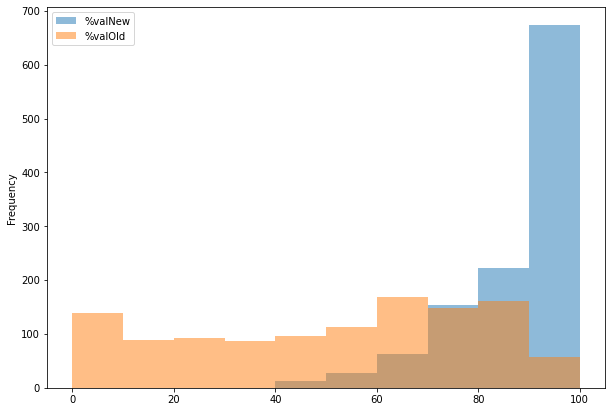

In [12]:
checks[["%valNew", "%valOld"]].plot.hist(figsize=(10, 7), alpha=0.5, bins=10)
plt.show()